In [20]:
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import pickle
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# import data, access pandas df via key "None"
X_Govaere = pyreadr.read_r("datasets/X_Govaere.rds")[None]
X_Hoang = pyreadr.read_r("datasets/X_Hoang.rds")[None]
X_Pantano = pyreadr.read_r("datasets/X_Pantano.rds")[None]

# actual, clinical results
Y_Govaere = pyreadr.read_r("datasets/Y_Govaere.rds")[None]
Y_Hoang = pyreadr.read_r("datasets/Y_Hoang.rds")[None]
Y_Pantano = pyreadr.read_r("datasets/Y_Pantano.rds")[None]

# viper metric, predicted results
Y_viper_Govaere = pyreadr.read_r("datasets/viper_X_Govaere.rds")[None]
Y_viper_Hoang = pyreadr.read_r("datasets/viper_X_Hoang.rds")[None]
Y_viper_Pantano = pyreadr.read_r("datasets/viper_X_Pantano.rds")[None]

In [4]:
# StratifiedKFold will split datasets evenly amongst the classes
# shuffle=True will shuffle each class's samples before splitting into batches
# random_state=5 will guarantee reproducible output across multiple function calls

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

In [5]:
X = X_Govaere
Y = Y_Govaere

In [6]:
num_lvs = range(2, 11)

In [7]:
def pair_pearsonr(x, y, axis=0): # this will allow us to take the pearson coefficient across two variables
    mx = np.mean(x, axis=axis, keepdims=True)
    my = np.mean(y, axis=axis, keepdims=True)
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym, axis=axis)
    r_den = np.sqrt((xm*xm).sum(axis=axis) * (ym*ym).sum(axis=axis))
    r = r_num / r_den
    return r

In [ ]:
# checking that pearson_r is equivalent to taking the mean of pair_pearsonr
# np.mean(pair_pearsonr(Y_test.values, Y_test_hat))
corr_test, _ = pearsonr(Y_test.values[:,0], Y_test_hat[:, 0])
print(corr_test)

In [27]:
values, frequency = np.unique(Y[Y.columns[1]], return_counts=True)

print(f'{values=}, {frequency=}')


values=array([0, 1, 2, 3, 4], dtype=int32), frequency=array([39, 43, 51, 47, 14])


In [8]:
pearson_coeff_lvs = [] # containing tuples (num_lv, avg pearson coeff)

for latent_var in num_lvs:
    
    pearson_coeff = []
    
    for i, (train_index, test_index) in enumerate(skf.split(X, Y["fibrosis"])): # index into "fibrosis" only because we need the correct size for finding indices

        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        Y_train = Y.iloc[train_index]
        Y_test = Y.iloc[test_index]
        # print(f'{Y_test=}')

        model = PLSRegression(n_components=latent_var, scale=False)
        model.fit(X_train, Y_train)
        Y_test_hat = model.predict(X_test)
        # print(f'{Y_test_hat=}')
        # corr_test, _ = pearsonr(Y_test.values, Y_test_hat)
        # pearson_coeff.append(corr_test)
        pearson_coeff.append(np.mean(pair_pearsonr(Y_test.values, Y_test_hat))) # take the mean in order to be able to generalize the behavior on both phenotypes
        
        
    pearson_coeff_lvs.append((latent_var, sum(pearson_coeff)/len(pearson_coeff))) # evaluate based on the average across all 10 folds

In [9]:
print(max(pearson_coeff_lvs, key=lambda x: x[1])) # tells us that 8 lvs is optimal!!
# print(max(pearson_coeff_lvs_nas, key=lambda x: x[1]))

(8, 0.6914184288420416)


In [43]:
# save the model so we can run it again!
# store the pearson's coeff for training and validation sets

latent_var = 8 # our best performing hyperparameter
train_pearson_coeff_fib = []
train_pearson_coeff_nas = []
test_pearson_coeff_fib = []
test_pearson_coeff_nas = []

for i, (train_index, test_index) in enumerate(skf.split(X, Y["fibrosis"])):

    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    Y_train = Y.iloc[train_index]
    Y_test = Y.iloc[test_index]

    model = PLSRegression(n_components=latent_var, scale=False)
    model.fit(X_train, Y_train)
    
    Y_train_hat = model.predict(X_train) 
    corr_test_fib, _ = pearsonr(Y_train.values[:,0], Y_train_hat[:,0]) # fibrosis correlation
    corr_test_nas, _ = pearsonr(Y_train.values[:,1], Y_train_hat[:,1]) # NAS correlation
    train_pearson_coeff_fib.append(corr_test_fib)
    train_pearson_coeff_nas.append(corr_test_nas)
    
    Y_test_hat = model.predict(X_test) 
    corr_test_fib, _ = pearsonr(Y_test.values[:,0], Y_test_hat[:,0]) # fibrosis correlation
    corr_test_nas, _ = pearsonr(Y_test.values[:,1], Y_test_hat[:,1]) # NAS correlation
    test_pearson_coeff_fib.append(corr_test_fib)
    test_pearson_coeff_nas.append(corr_test_nas)

    # break
    filename = f"models/Govaere_PLSR_fold_{i}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    
    print(f"Model for Fold {i} saved as {filename}")

Model for Fold 0 saved as models/Govaere_PLSR_fold_0.pkl
Model for Fold 1 saved as models/Govaere_PLSR_fold_1.pkl
Model for Fold 2 saved as models/Govaere_PLSR_fold_2.pkl
Model for Fold 3 saved as models/Govaere_PLSR_fold_3.pkl
Model for Fold 4 saved as models/Govaere_PLSR_fold_4.pkl
Model for Fold 5 saved as models/Govaere_PLSR_fold_5.pkl
Model for Fold 6 saved as models/Govaere_PLSR_fold_6.pkl
Model for Fold 7 saved as models/Govaere_PLSR_fold_7.pkl
Model for Fold 8 saved as models/Govaere_PLSR_fold_8.pkl
Model for Fold 9 saved as models/Govaere_PLSR_fold_9.pkl


In [44]:
# run on the Hoang and Pantano test sets
# load all models

loaded_models = []
for i in range(0, 10):
    filename = f"models/Govaere_PLSR_fold_{i}.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
        loaded_models.append(model)
    print(f"Loaded model {i} from {filename}")

Loaded model 0 from models/Govaere_PLSR_fold_0.pkl
Loaded model 1 from models/Govaere_PLSR_fold_1.pkl
Loaded model 2 from models/Govaere_PLSR_fold_2.pkl
Loaded model 3 from models/Govaere_PLSR_fold_3.pkl
Loaded model 4 from models/Govaere_PLSR_fold_4.pkl
Loaded model 5 from models/Govaere_PLSR_fold_5.pkl
Loaded model 6 from models/Govaere_PLSR_fold_6.pkl
Loaded model 7 from models/Govaere_PLSR_fold_7.pkl
Loaded model 8 from models/Govaere_PLSR_fold_8.pkl
Loaded model 9 from models/Govaere_PLSR_fold_9.pkl


In [12]:
# create shuffled dataset from Govaere
X_shuffled_genes = X.apply(lambda col: np.random.permutation(col.values), axis=0)
X_Govaere_shuffled = X_Govaere.apply(lambda col: np.random.permutation(col.values), axis=0)
X_Govaere_shuffled.index = X_Govaere.index # ensure the gene names are maintained

In [46]:
# run on Hoang, Pantano, and shuffled Govaere dataset
Hoang_pearson_coeff_fib = []
Hoang_pearson_coeff_nas = []
Pantano_pearson_coeff_fib = []
Pantano_pearson_coeff_nas = []
shuffled_pearson_coeff_fib = []
shuffled_pearson_coeff_nas = []

for i, model in enumerate(loaded_models):
    Y_pred = model.predict(X_Hoang)
    corr_test_fib, _ = pearsonr(Y_Hoang.values[:,0], Y_pred[:,0]) # fibrosis correlation
    corr_test_nas, _ = pearsonr(Y_Hoang.values[:,1], Y_pred[:,1]) # NAS correlation
    Hoang_pearson_coeff_fib.append(corr_test_fib)
    Hoang_pearson_coeff_nas.append(corr_test_nas)

    Y_pred = model.predict(X_Pantano)
    corr_test_fib, _ = pearsonr(Y_Pantano.values[:,0], Y_pred[:,0]) # fibrosis correlation
    corr_test_nas, _ = pearsonr(Y_Pantano.values[:,1], Y_pred[:,1]) # NAS correlation
    Pantano_pearson_coeff_fib.append(corr_test_fib)
    Pantano_pearson_coeff_nas.append(corr_test_nas)

    Y_pred = model.predict(X_Govaere_shuffled)
    corr_test_fib, _ = pearsonr(Y_Govaere.values[:,0], Y_pred[:,0]) # fibrosis correlation
    corr_test_nas, _ = pearsonr(Y_Govaere.values[:,1], Y_pred[:,1]) # NAS correlation
    shuffled_pearson_coeff_fib.append(corr_test_fib)
    shuffled_pearson_coeff_nas.append(corr_test_nas)


In [14]:
# Hoang_pearson_coeff_fib
# Hoang_pearson_coeff_nas
# Pantano_pearson_coeff_fib
# Pantano_pearson_coeff_nas
# shuffled_pearson_coeff_fib
# shuffled_pearson_coeff_nas
test_pearson_coeff_fib

[0.672033905482859,
 0.8273739507352478,
 0.754019407143882,
 0.6427572798117623,
 0.4761568345858711,
 0.8057942573718496,
 0.5391044328500764,
 0.6272482186585724,
 0.6273783408008892,
 0.7933399386237254]

In [47]:
# store all pearson correlation coefficients in a dataframe
all_nas_coeff = {
    'Train': train_pearson_coeff_fib,
    'Validation': test_pearson_coeff_fib,
    'Hoang': Hoang_pearson_coeff_fib,
    'Pantano': Pantano_pearson_coeff_fib,
    'Shuffled': shuffled_pearson_coeff_fib
}

all_nas_pearsons_coeff = pd.DataFrame(all_nas_coeff)

In [48]:
all_fib_coeff = {
    'Train': train_pearson_coeff_nas,
    'Validation': test_pearson_coeff_nas,
    'Hoang': Hoang_pearson_coeff_nas,
    'Pantano': Pantano_pearson_coeff_nas,
    'Shuffled': shuffled_pearson_coeff_nas
}

all_fib_pearsons_coeff = pd.DataFrame(all_fib_coeff)

In [49]:
all_nas_pearsons_coeff

,Train,Validation,Hoang,Pantano,Shuffled
0,0.942727,0.672034,0.755010,0.673803,-0.075133
1,0.945330,0.827374,0.735918,0.659793,0.031405
2,0.951762,0.754019,0.733375,0.700446,0.006278
3,0.956925,0.642757,0.726579,0.649996,0.005850
4,0.955011,0.476157,0.750075,0.616136,-0.004443
5,0.951345,0.805794,0.750164,0.642188,0.021223
6,0.963294,0.539104,0.740454,0.711470,-0.004835
7,0.948465,0.627248,0.752417,0.695764,0.020767
8,0.952015,0.627378,0.759299,0.636006,-0.005588
9,0.950553,0.793340,0.710253,0.657505,-0.002364


In [209]:
filename = f"graphs/PLSR_tuning_with_Govaere_nas_coeff.pkl"
with open(filename, 'wb') as file:
    pickle.dump(all_nas_pearsons_coeff, file)

In [51]:
# creating a better all_coeff dataframe
training_dataset = "Govaere"
X_test1 = X_Hoang
X_test2 = X_Pantano
Y_test1 = Y_Hoang
Y_test2 = Y_Pantano
test1 = "Hoang"
test2 = "Pantano"

results = [] # initialize list of all results

# train_pearson_coeff = []
# validation_pearson_coeff = []
# test1_pearson_coeff = []
# test2_pearson_coeff = []
# shuffled_pearson_coeff = []

X_shuffled = X.apply(lambda col: np.random.permutation(col.values), axis=0)
X_shuffled.index = X.index # ensure the gene names are maintained


# for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[1]])):
for i, (train_index, test_index) in enumerate(skf.split(X, Y["fibrosis"])):

    # split data
    X_train = X.iloc[train_index]
    X_val = X.iloc[test_index]
    Y_train = Y.iloc[train_index]
    Y_val = Y.iloc[test_index]

    partitions = [[X_train, X_val, X_test1, X_test2, X_shuffled], [Y_train, Y_val, Y_test1, Y_test2, Y], ["Train", "Validation", test1, test2, "Shuffled"]]


    # model = PLSRegression(n_components=latent_var, scale=False)
    print(f'{i=}')
    model = loaded_models[i]
    # model.fit(X_train, Y_train)

    for j in range(len(partitions[0])):
        
        Y_hat = model.predict(partitions[0][j])
        corr_nas, _ = pearsonr(partitions[1][j].values[:,0], Y_hat[:,0]) # NAS correlation
        corr_fib, _ = pearsonr(partitions[1][j].values[:,1], Y_hat[:,1]) # fibrosis correlation
        corr_mean = np.mean(pair_pearsonr(partitions[1][j].values, Y_hat)) # mean correlation
        
        results.append({
            "TuningDataset": training_dataset,  # Change if running for multiple datasets
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Fibrosis",  # Change or split if phenotypes are separate
            "Pearson_Coefficient": corr_fib
        })
        results.append({
            "TuningDataset": training_dataset,  # Change if running for multiple datasets
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "NAS",  # Change or split if phenotypes are separate
            "Pearson_Coefficient": corr_nas
        })
        results.append({
            "TuningDataset": training_dataset,  # Change if running for multiple datasets
            "Fold": f"Fold{i+1}",
            "Partition": partitions[2][j],
            "Phenotype": "Combined",  # Change or split if phenotypes are separate
            "Pearson_Coefficient": corr_mean
        })

    # # Validation partition Pearson coefficients
    # Y_val_hat = model.predict(X_val)
    # corr_test_fib, _ = pearsonr(Y_val.values[:,0], Y_val_hat[:,0]) # fibrosis correlation
    # corr_test_nas, _ = pearsonr(Y_val.values[:,1], Y_val_hat[:,1]) # NAS correlation
    # val_pearson = np.mean(pair_pearsonr(Y_val.values, Y_val_hat)) # mean correlation
    
    # results.append({
    #     "TuningDataset": training_dataset,  
    #     "Fold": f"Fold{i+1}",
    #     "Partition": "Validation",
    #     "Phenotype": "Fibrosis",  
    #     "Pearson_Coefficient": corr_test_fib
    # })
    # results.append({
    #     "TuningDataset": training_dataset,  
    #     "Fold": f"Fold{i+1}",
    #     "Partition": "Validation",
    #     "Phenotype": "NAS", 
    #     "Pearson_Coefficient": corr_test_nas
    # })
    # results.append({
    #     "TuningDataset": training_dataset, 
    #     "Fold": f"Fold{i+1}",
    #     "Partition": "Validation",
    #     "Phenotype": "Combined", 
    #     "Pearson_Coefficient": train_pearson
    # })
    

    # # Test1 Pearson coefficients
    # Y_pred_test1 = model.predict(X_test1)
    # corr_test_fib, _ = pearsonr(Y_test1.values[:,0], Y_val_hat[:,0]) # fibrosis correlation
    # corr_test_nas, _ = pearsonr(Y_test1.values[:,1], Y_val_hat[:,1]) # NAS correlation
    # test1_pearson = np.mean(pair_pearsonr(Y_val.values, Y_val_hat)) # mean correlation
    
    # results.append({
    #     "TuningDataset": training_dataset,  
    #     "Fold": f"Fold{i+1}",
    #     "Partition": "Validation",
    #     "Phenotype": "Fibrosis",  
    #     "Pearson_Coefficient": corr_test_fib
    # })
    # results.append({
    #     "TuningDataset": training_dataset,  
    #     "Fold": f"Fold{i+1}",
    #     "Partition": "Validation",
    #     "Phenotype": "NAS", 
    #     "Pearson_Coefficient": corr_test_nas
    # })
    # results.append({
    #     "TuningDataset": training_dataset, 
    #     "Fold": f"Fold{i+1}",
    #     "Partition": "Validation",
    #     "Phenotype": "Combined", 
    #     "Pearson_Coefficient": train_pearson
    # })
    
    # test1_pearson = np.mean(pair_pearsonr(Y_test1.values, Y_pred_test1))
    # results.append({
    #     "Dataset": "Dataset1",
    #     "Fold": f"Fold{i+1}",
    #     "Partition": test1,
    #     "Phenotype": "Combined",
    #     "Pearson_Coefficient": test1_pearson
    # })

    # # Test2 Pearson coefficients
    # Y_pred_test2 = model.predict(X_test2)
    # test2_pearson = np.mean(pair_pearsonr(Y_test2.values, Y_pred_test2))
    # results.append({
    #     "Dataset": "Dataset1",
    #     "Fold": f"Fold{i+1}",
    #     "Partition": test2,
    #     "Phenotype": "Combined",
    #     "Pearson_Coefficient": test2_pearson
    # })

    # # Shuffled Pearson coefficients
    # Y_pred_shuffled = model.predict(X_shuffled)
    # shuffled_pearson = np.mean(pair_pearsonr(Y.values, Y_pred_shuffled))
    # results.append({
    #     "Dataset": "Dataset1",
    #     "Fold": f"Fold{i+1}",
    #     "Partition": "Shuffled",
    #     "Phenotype": "Combined",
    #     "Pearson_Coefficient": shuffled_pearson
    # })

i=0
i=1
i=2
i=3
i=4
i=5
i=6
i=7
i=8
i=9


In [53]:
results_df = pd.DataFrame(results)
results_df[(results_df["Phenotype"] == "NAS") & (results_df["Partition"] == "Validation")]
# results_df

,TuningDataset,Fold,Partition,Phenotype,Pearson_Coefficient
4,Govaere,Fold1,Validation,NAS,0.672034
19,Govaere,Fold2,Validation,NAS,0.827374
34,Govaere,Fold3,Validation,NAS,0.754019
49,Govaere,Fold4,Validation,NAS,0.642757
64,Govaere,Fold5,Validation,NAS,0.476157
79,Govaere,Fold6,Validation,NAS,0.805794
94,Govaere,Fold7,Validation,NAS,0.539104
109,Govaere,Fold8,Validation,NAS,0.627248
124,Govaere,Fold9,Validation,NAS,0.627378
139,Govaere,Fold10,Validation,NAS,0.793340


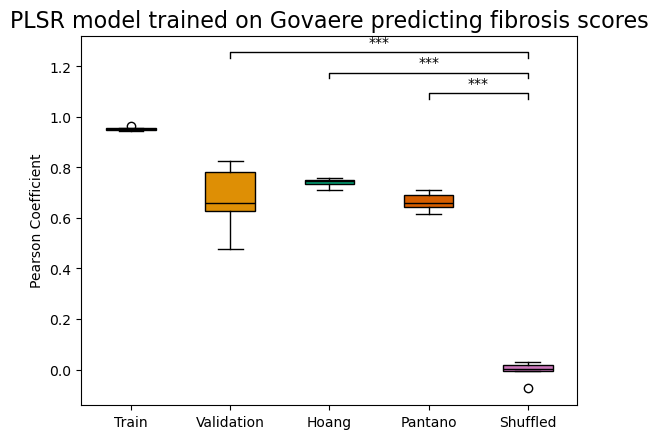

In [21]:
significant_combinations = []
all_pearsons_coeff = all_fib_pearsons_coeff # TODO: CHANGE
training_dataset = "Govaere" # TODO: CHANGE

combinations = [(x, 4) for x in [1, 2, 3]]
for combo in combinations:
    data1 = all_pearsons_coeff.iloc[:,combo[0]]
    data2 = all_pearsons_coeff.iloc[:,combo[1]]
    
    # calculate significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combo, p])

# create a set of axes
ax = plt.axes()
# create a boxplot on the axes
bp = ax.boxplot(all_pearsons_coeff, patch_artist=True)
# graph title
ax.set_title(f"PLSR model trained on {training_dataset} predicting fibrosis scores", fontsize=16) # TODO: CHANGE
# label y-axis
ax.set_ylabel("Pearson Coefficient")

xticklabels = all_pearsons_coeff.columns.tolist()
ax.set_xticklabels(xticklabels)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('colorblind')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    # add one because the df indexing is 0 indexed, but plot is 1 indexed
    x1 = significant_combination[0][0] + 1 
    x2 = significant_combination[0][1] + 1
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

plt.savefig(f'graphs/PLSR_tuning_with_{training_dataset}_predicting_fib.png', dpi=200) # TODO: CHANGE
plt.show()

### excess

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [90]:
# Make figures A6 in size
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
# Use LaTeX for graphs' text
plt.rc('text', usetex=True)
# Use the serif font
plt.rc('font', family='serif')

In [120]:
all_pearsons_coeff.iloc[:,4]

0    0.108127
1    0.079802
2    0.107090
3    0.113206
4    0.100203
5    0.094683
6    0.103404
7    0.066955
8    0.064553
9    0.068372
Name: Shuffled, dtype: float64

In [122]:
significant_combinations = []

combinations = [(x, 4) for x in [1, 2, 3]]
for combo in combinations:
    data1 = all_pearsons_coeff.iloc[:,combo[0]]
    data2 = all_pearsons_coeff.iloc[:,combo[1]]
    # calculate significance

    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combo, p])

In [124]:
significant_combinations

[[(1, 4), 0.00018267179110955002],
 [(2, 4), 0.00018267179110955002],
 [(3, 4), 0.00018267179110955002]]

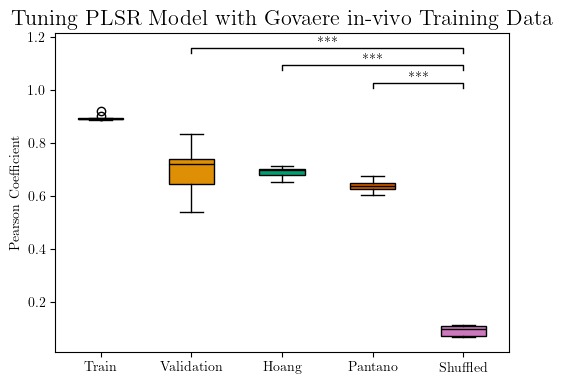

In [132]:
# create a set of axes
ax = plt.axes()
# create a boxplot on the axes
bp = ax.boxplot(all_pearsons_coeff, patch_artist=True)
# graph title
ax.set_title("Tuning PLSR Model with Govaere in-vivo Training Data", fontsize=16)
# label y-axis
ax.set_ylabel("Pearson Coefficient")

xticklabels = all_pearsons_coeff.columns.tolist()
ax.set_xticklabels(xticklabels)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('colorblind')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    # add one because the df indexing is 0 indexed, but plot is 1 indexed
    x1 = significant_combination[0][0] + 1 
    x2 = significant_combination[0][1] + 1
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

plt.show()

In [134]:
significant_combinations

[[(1, 4), 0.00018267179110955002],
 [(2, 4), 0.00018267179110955002],
 [(3, 4), 0.00018267179110955002]]